# This is a notebook for producing tSNE downscaled plots of Molecules produced by LSTM, PGFS and those in the filtered enamine set.

In [1]:
import os
os.chdir('../')
os.getcwd()

'/home/boto/chemPGFS/gymPGFS'

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from gym_PGFS.chemwrapped import MolDSetDescriptorsNumpy, ChemMolFromSmilesWrapper
from sklearn.manifold import TSNE

In [3]:
run_dirs = {'./data/run_B_long': 'CHEMBL3888429', 
            './data/run_A_long': 'CHEMBL1909140', 
            './data/run_C_long': 'CHEMBL1909203'}
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

lstm_out = {}

for name in dsets:
    lstm_out[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")
    
# now do the same for an output of pgfs


pgfs_out = {}

for location, name in run_dirs.items():
    df = pd.read_csv(f"{location}/smiles_collected.csv")
    print(len(df))
    print(df['step'].unique()) 
    print("Picking 5")
    df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])
    pgfs_out[name] = df


# load the datasets used to train the classifiers for OS and MCS
mcs_data = {}
dcs_data = {}

## TODO: brush up/find out what exactly does my version of MolD contain 

for name in dsets:
    dcs_data[name] = pd.read_csv(f"./data/mgenfail_assays/{name}/DCS_SPLIT.csv")

for name in dsets:
    mcs_data[name] = pd.read_csv(f"./data/mgenfail_assays/{name}/MCS_SPLIT.csv")
    
    

108000
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5


In [4]:
# compute restrict the molecule to the last epoch as well as to only one set of smiles
lstms = {}
pgfss = {}
for dataset_name in pgfs_out.keys():
    # get the lstm and pgfs datasets ( only dcs scores of the last epoch )
    lstm = lstm_out[dataset_name]
    last_lstm = lstm.epoch.max()
    lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)]
    
    # compute the fingerprints
    lstm = np.stack(lstm.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    pgfs = pgfs_out[dataset_name]
    last_pgfs = pgfs.epoch.max()
    pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)]
    
    # compute the fingerprints
    pgfs = np.stack(pgfs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # now make a boxplot
    lstms[dataset_name] = lstm
    pgfss[dataset_name] = pgfs
    


In [5]:
dcss_p = {}
dcss_m = {}
mcss_p = {}
mcss_m = {}

for dataset_name in dsets:
    print(dataset_name)
    # compute the fingerprints
    dcs = dcs_data[dataset_name]
    dcs = dcs[dcs.label>0]
    print(len(dcs))
    dcs = np.stack(dcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # compute the fingerprints
    mcs = mcs_data[dataset_name]
    mcs = mcs[mcs.label>0]
    print(len(mcs))
    mcs = np.stack(mcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())

    # now make a boxplot
    dcss_p[dataset_name] = dcs
    mcss_p[dataset_name] = mcs
    
    # compute the fingerprints
    dcs = dcs_data[dataset_name]
    dcs = dcs[dcs.label<1]
    print(len(dcs))
    dcs = np.stack(dcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # compute the fingerprints
    mcs = mcs_data[dataset_name]
    mcs = mcs[mcs.label<1]
    print(len(mcs))
    mcs = np.stack(mcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())

    # now make a boxplot
    dcss_m[dataset_name] = dcs
    mcss_m[dataset_name] = mcs
    

CHEMBL3888429
70
70
264
263
CHEMBL1909140
29
30
392
391
CHEMBL1909203
20
20
401
401


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1447 samples in 0.002s...
[t-SNE] Computed neighbors for 1447 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1447
[t-SNE] Computed conditional probabilities for sample 1447 / 1447
[t-SNE] Mean sigma: 1.604884
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.434654
[t-SNE] KL divergence after 1000 iterations: 0.729896
480
(967, 2)
300
(667, 2)
70
(597, 2)
264
(333, 2)
70
(263, 2)
263
(0, 2)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1623 samples in 0.002s...
[t-SNE] Computed neighbors for 1623 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1623
[t-SNE] Computed conditional probabilities for sample 1623 / 1623
[t-SNE] Mean sigma: 1.075838
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.123245
[t-SNE] KL divergence after 1000 iterations: 0.913863
481
(1142, 2)
300
(842, 2)
29
(813, 2)
392
(421, 2)
30
(39

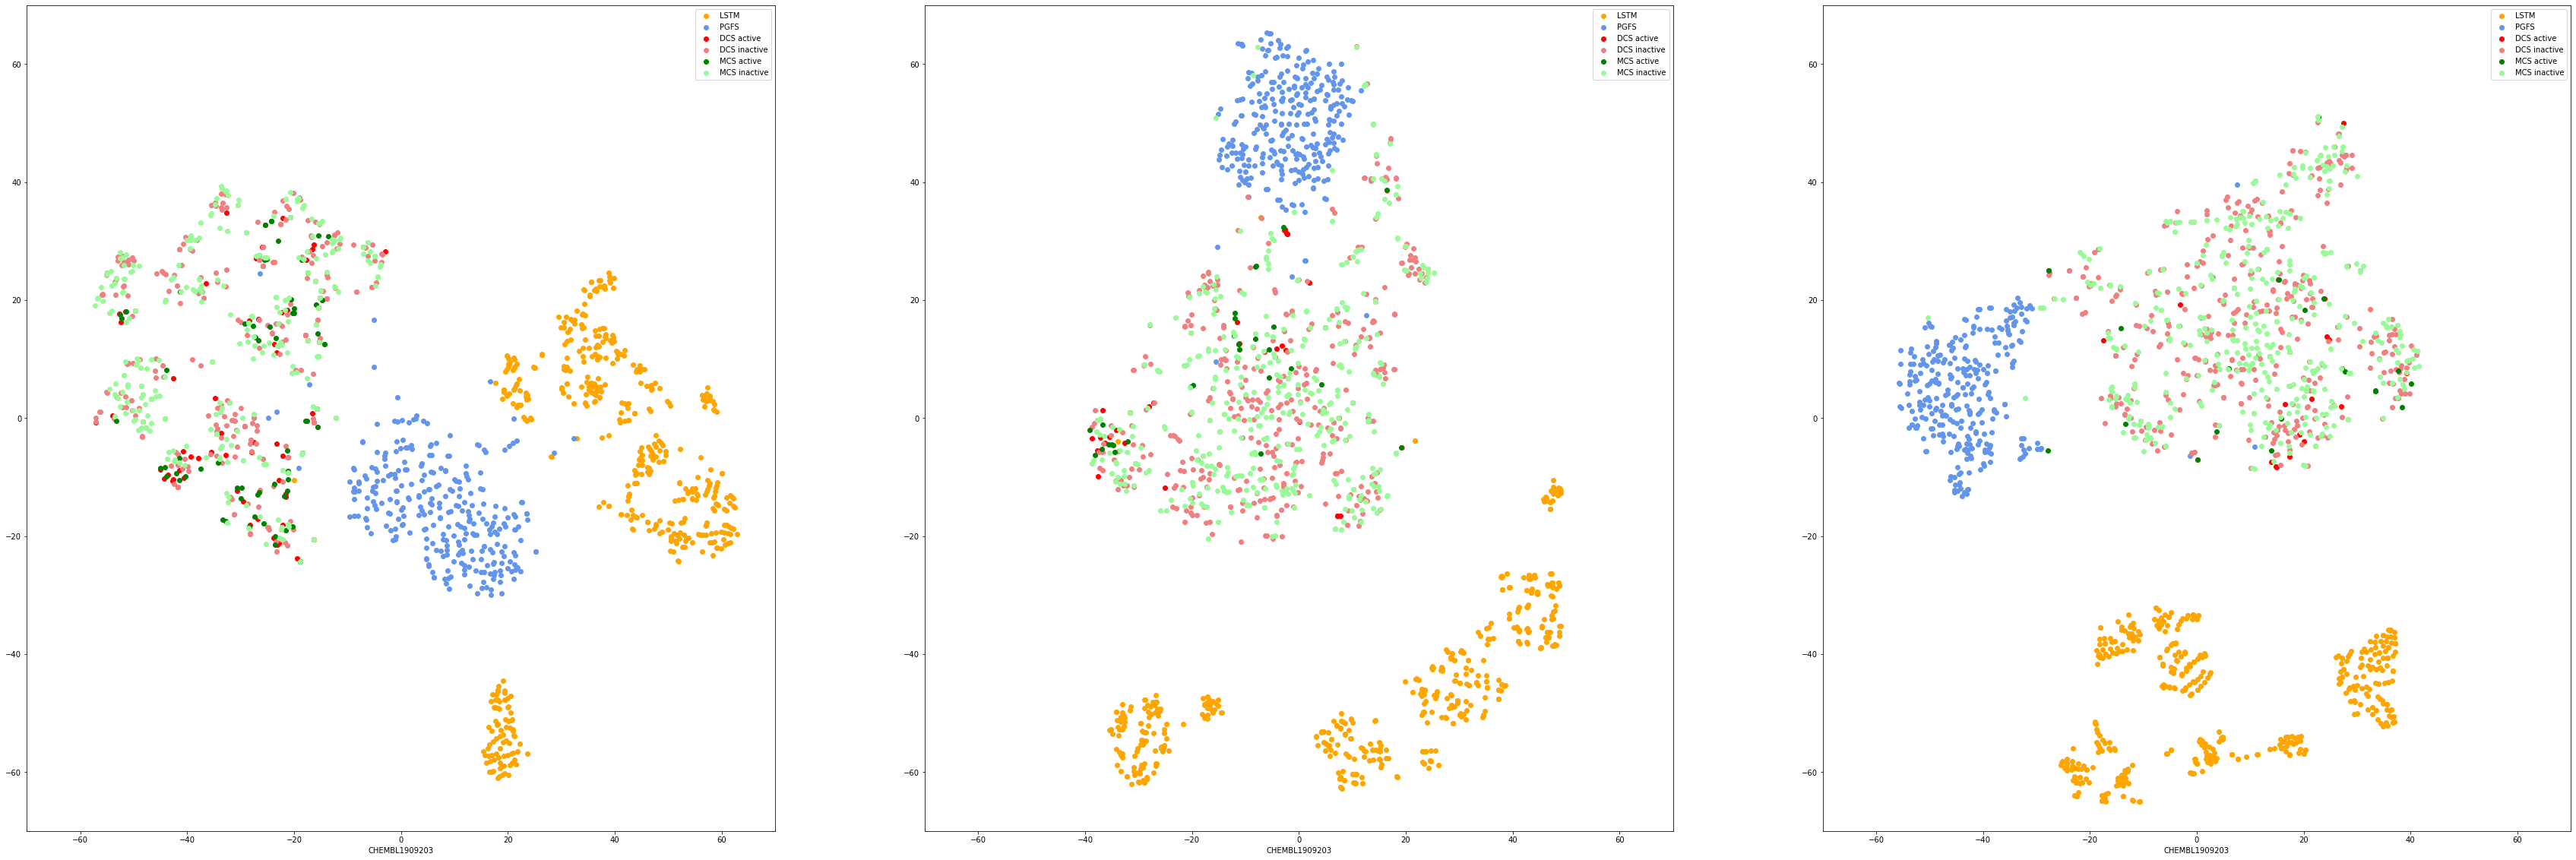

In [6]:
fig, axs = plt.subplots(1,3,figsize=(60,20))
for name, ax in zip(dsets, axs):
    tisne = TSNE(n_components=2, init='random', verbose=1, n_jobs=-1)
    
    # get all the data together from this dataset
    all_data = np.concatenate([lstms[name], pgfss[name], dcss_p[name], dcss_m[name], mcss_p[name], mcss_m[name]])
    # get rid of the molecular weight : it disrupts things
    all_data = np.delete(all_data, 4, axis=1)
    # normalize the data
    all_data = (all_data-np.mean(all_data, axis=0))/np.std(all_data, axis=0)
    
    # fit the tsne
    re_data = tisne.fit_transform(all_data)
    
    # now get the data and plot
    ax.set_xlim((-70, 70))
    ax.set_ylim((-70, 70))
    ax.set_xlabel(dataset_name)
    for src, src_label, color in [[lstms, 'LSTM', 'orange'], [pgfss, 'PGFS', 'cornflowerblue'],[dcss_p, 'DCS active', 'red'], [dcss_m, 'DCS inactive', 'lightcoral'], 
                                  [mcss_p, 'MCS active', 'green'], [mcss_m, 'MCS inactive', 'palegreen']]:
        sz = src[name].shape[0]
        print(sz)
        src_data = re_data[:sz, :]
        re_data = re_data[sz:, :]
        print(re_data.shape)
        ax.scatter(src_data[:, 0], src_data[:, 1], c=color, label=src_label)
    ax.legend()
    

In [7]:
# list(pgfss.values())[0][0, :]

array([ 1.51782526e+01, -1.11118716e+00,  7.40912170e-02,  4.53843393e-02,
        8.18698000e+02,  1.24074074e+00,  1.77882823e+00,  3.60817008e+01,
        4.82717407e+00,  1.59299439e+01,  8.87802596e+01,  3.56449928e+01,
        3.06615467e+01,  7.48613372e+01,  3.20283783e+01,  7.93598826e+01,
        2.37995173e+01,  4.19011586e+01,  2.35302432e+01,  2.54490283e+01,
        4.06850531e+01,  4.72222222e-01,  6.01462000e+00,  1.77099054e+01,
        1.49088555e+01,  9.49596862e+01,  2.48348446e+01,  1.06334667e+01,
        6.95658975e+00,  5.72304500e+01,  1.70380555e+01,  3.66688085e+01,
        3.65314781e+01,  2.50507837e+01,  1.27300862e+00])

In [ ]:
# try to do the sam, but using PCA on ECFP4 fingerprints

# See what features are important for the MCS and the DCS models

In [1]:
import os
os.chdir('../')
os.getcwd()

'/home/boto/chemPGFS/gymPGFS'

In [2]:
from scorers import scorer
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle
from matplotlib import pyplot as plt
from gym_PGFS.scorers.scorer import GuacamolMGenFailScorer
from gym_PGFS.valuation.plot_utils import plot_medians, process_output_into_dataframe

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.inspection import permutation_importance

In [4]:
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']
modes = ['DCS', 'MCS', 'OS']
opposites = ['MCS', 'DCS', 'DCS']

models = {}
datas = {}

for dset in dsets:
    models[dset] = {}
    datas[dset] = {}
    
    for mode in modes:
        # load the clasifier and the data
        if not mode is 'OS':
            datas[dset][mode] = pd.read_csv(f"./data/mgenfail_assays/{dset}/{mode}_SPLIT.csv")
        else:
            datas[dset][mode] = datas[dset]['MCS']

        with open(f"./data/mgenfail_assays/{dset}/{mode}_MODEL/model.pkl", "rb") as f:
            models[dset][mode] = pickle.load(f)
    

0 0 0 ... 0 0 0


array([ 0,  0,  0, -1,  0,  0,  0])

In [17]:
# now compute the bitinfos
bit_substructs = defaultdict(lambda : [])

for dset in dsets:
    for mode in modes:
        for smi in datas[dset][mode].smiles.tolist():
            info = {}
            m =Chem.MolFromSmiles(smi)
            # ECFP4 fingerprints of len 1024 as trained for the molecules
            fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024, bitInfo=info)
            # now record the molecule fragments
#             print(info)
            for bit, substruct in info.items():
                for center, radius in substruct:
                    env = Chem.FindAtomEnvironmentOfRadiusN(m,radius,center)
                    submol=Chem.PathToSubmol(m,env)
                    bit_substructs[bit].append(submol)
#                     display(submol)
#                     assert False
            
        
        # now get the feature importances from the 

In [31]:
from io import StringIO
feature_importances = {}

for dset in dsets:
    feature_importances[dset] = {}
    for mode, opp in zip(modes, opposites):
        test_set = datas[dset][opp]
        X_test = np.stack([np.genfromtxt(StringIO(s[1:-1]), delimiter=',', dtype='float') for s in test_set.descriptors.tolist()])
        y_test = np.stack(test_set.label.tolist())
        feature_importances[dset] = permutation_importance(models[dset][mode],
                                                           X_test, y_test,
                                                           n_repeats=10, n_jobs=-1)

ValueError: Expected 2D array, got 1D array instead:
array=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.